In [7]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}

import os
root = '/data/eeg/scalp/ltp/'
experiment = 'ltpRepFR'
with open(os.path.join(root, experiment, 'wordpool.txt'), "r") as f:
    wordpool = [w.strip().upper() for w in f.readlines()]
wordpool.pop(0)

item_num_df = pd.DataFrame({'item_name': wordpool}).reset_index()
item_num_df.rename(columns={'index': 'item_num'}, inplace=True)

In [8]:
evs = []
data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
for subject, df in data.groupby('subject'):
    for session in pd.unique(df['session']):
        r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
        temp = r.load('all_events')
        evs.append(temp)
evs = pd.concat(evs)

evs = evs.merge(item_num_df, on='item_name', suffixes=('', '_new'))
test_evs = evs.query('type == ["WORD", "REC_WORD"] and item_num >= 0')
test_evs.query('item_num != item_num_new')

evs = evs[evs.list != 0]
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']


In [9]:
agg=[]

for i, beh in evs.groupby(['subject', 'session']):
    word_evs = beh[beh.type=='WORD']
    word_evs = word_evs.loc[word_evs.repeats != -999]
    word_evs = word_evs[word_evs.repeats != 0]
    rec_evs = beh[beh.type=='REC_WORD']
    rec_wrds = word_evs[word_evs.recalled == 1].item_num_new.unique()
    no_rec = word_evs[word_evs.recalled == 0].item_num_new.unique()
    ffr = rec_evs[rec_evs.list == 26]
    ffr = ffr[ffr.item_num_new != -1]
    ffr = ffr.drop_duplicates('item_num_new')
    word_evs = word_evs.drop_duplicates('item_num_new')
    count = pd.DataFrame()
    count['denom'] = word_evs.groupby(['repeats', 'recalled', 'list']).item_num_new.count()
    ffr.set_index('item_num_new', inplace=True)
    word_evs.set_index('item_num_new', inplace=True)
    ffr['list'] = word_evs.list
    ffr['recalled'] = word_evs.recalled
    ffr.reset_index(inplace=True)
    count['numer'] = ffr.groupby(['repeats', 'recalled', 'list']).item_num_new.count()
    count.fillna(0, inplace=True)
    sub,sess=i
    count['sub'] = pd.Series(sub, count.index)
    count['sess'] = pd.Series(sess, count.index)
    count = count.reset_index()
    agg.append(count)
counted = pd.concat(agg, ignore_index = True)
summed = counted.groupby(['sub', 'repeats', 'recalled', 'list']).sum()
summed['prop'] = summed.numer/summed.denom
summed.reset_index(inplace=True)


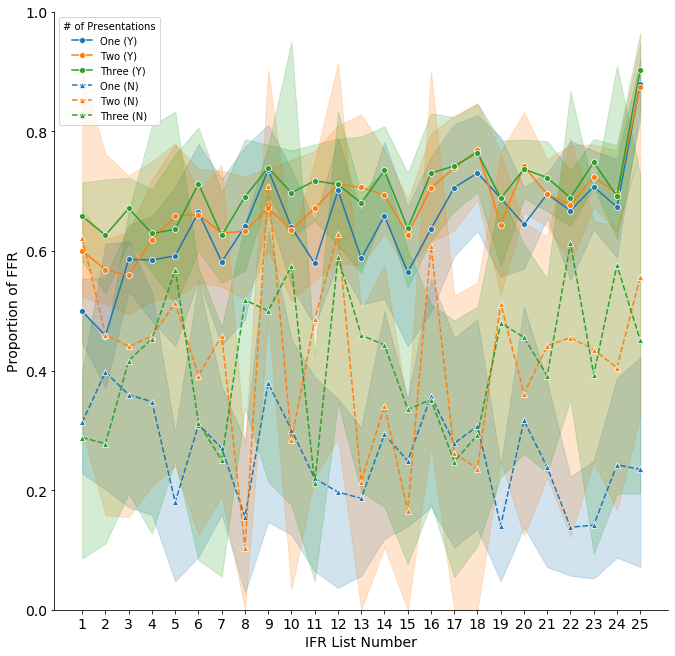

In [10]:

# (counted.groupby(['repeats', 'recalled', 'orig_list']).item_num.sum()/counted.item_num.sum()).reset_index().

# counted[counted.subject=='LTP441'].sort_values(['orig_list', 'repeats', 'recalled'])

# pd.set_option('display.max_rows', None)
# counted.groupby(['repeats', 'recalled', 'orig_list']).item_num.std()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

no_one = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 1)]
no_two = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 2)]
no_thr = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 3)]

ye_one = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 1)]
ye_two = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 2)]
ye_thr = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 3)]

# no_rep = summed.groupby(['sub', 'recalled', 'list']).prop.mean().reset_index()
# no_no = no_rep[no_rep.recalled == 0]
# no_yes = no_rep[no_rep.recalled == 1]


set_axes(figsize = (11, 11), xticks = np.arange(1, 26), ylim = [0,1])
# sns.lineplot(data = no_yes, x = 'list', y = 'prop', linestyle = '-', marker = 'o', label = 'yes', color = 'black')
# sns.lineplot(data = no_no, x = 'list', y = 'prop', linestyle = '--', marker = '^', label = 'no', color = 'black')

g4 = sns.lineplot(data=ye_one, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'One (Y)', color = colors[0])
g5 = sns.lineplot(data=ye_two, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'Two (Y)', color = colors[1])
g6 = sns.lineplot(data=ye_thr, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'Three (Y)', color = colors[2])

g1 = sns.lineplot(data=no_one, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'One (N)', color = colors[0])
g2 = sns.lineplot(data=no_two, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Two (N)', color = colors[1])
g3 = sns.lineplot(data=no_thr, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Three (N)', color = colors[2])


_ = plt.legend(title = '# of Presentations')
_ = plt.xlabel('IFR List Number')
_ = plt.ylabel('Proportion of FFR')
# plt.savefig('scalp_figs/ffr_recalls.pdf')



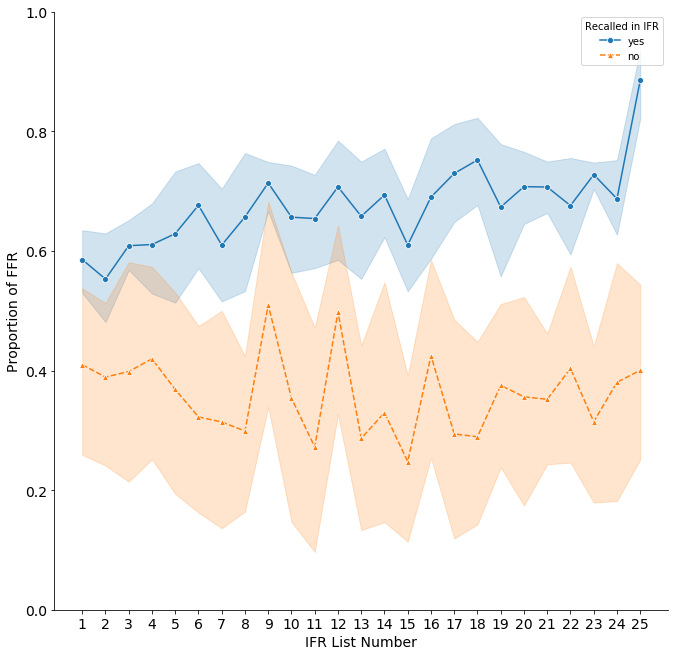

In [187]:
no_rep = summed.groupby(['sub', 'recalled', 'list']).prop.mean().reset_index()
no_no = no_rep[no_rep.recalled == 0]
no_yes = no_rep[no_rep.recalled == 1]


set_axes(figsize = (11, 11), xticks = np.arange(1, 26), ylim = [0,1])
sns.lineplot(data = no_yes, x = 'list', y = 'prop', linestyle = '-', marker = 'o', label = 'yes')
sns.lineplot(data = no_no, x = 'list', y = 'prop', linestyle = '--', marker = '^', label = 'no')

_ = plt.legend(title = 'Recalled in IFR')
_ = plt.xlabel('IFR List Number')
_ = plt.ylabel('Proportion of FFR')

plt.savefig('scalp_figs/ffr_rec_no_reps.pdf')

In [188]:
agg=[]

for i, beh in evs.groupby(['subject', 'session']):
    word_evs = beh[beh.type=='WORD']
    word_evs = word_evs.loc[word_evs.repeats != -999]
    word_evs = word_evs[word_evs.repeats != 0]
    rec_evs = beh[beh.type=='REC_WORD']
    rec_wrds = word_evs[word_evs.recalled == 1].item_num.unique()
    no_rec = word_evs[word_evs.recalled == 0].item_num.unique()
    ffr = rec_evs[rec_evs.list == 26]
    ffr = ffr[ffr.item_num != -1]
    ffr = ffr.drop_duplicates('item_num')
    word_evs = word_evs.drop_duplicates('item_num')
    count = pd.DataFrame()
    count['denom'] = word_evs.groupby(['repeats', 'recalled', 'list']).item_num.count()
    ffr.set_index('item_num', inplace=True)
    word_evs.set_index('item_num', inplace=True)
    ffr['list'] = word_evs.list
    ffr['recalled'] = word_evs.recalled
    ffr.reset_index(inplace=True)
    count['numer'] = ffr.groupby(['repeats', 'recalled', 'list']).item_num.count()
    count.fillna(0, inplace=True)
    sub,sess=i
    count['sub'] = pd.Series(sub, count.index)
    count['sess'] = pd.Series(sess, count.index)
    count = count.reset_index()
    agg.append(count)
counted = pd.concat(agg, ignore_index = True)
summed = counted.groupby(['sub', 'repeats', 'recalled', 'list']).sum()
summed['prop'] = summed.numer/summed.denom
summed.reset_index(inplace=True)
cuts = pd.qcut(summed.list, 9)
summed = summed.groupby([cuts, 'sub', 'repeats', 'recalled']).mean().drop('list', 1).reset_index()
summed['bin'] = summed['list'].apply(lambda x: x.right).astype(float).divide(3)

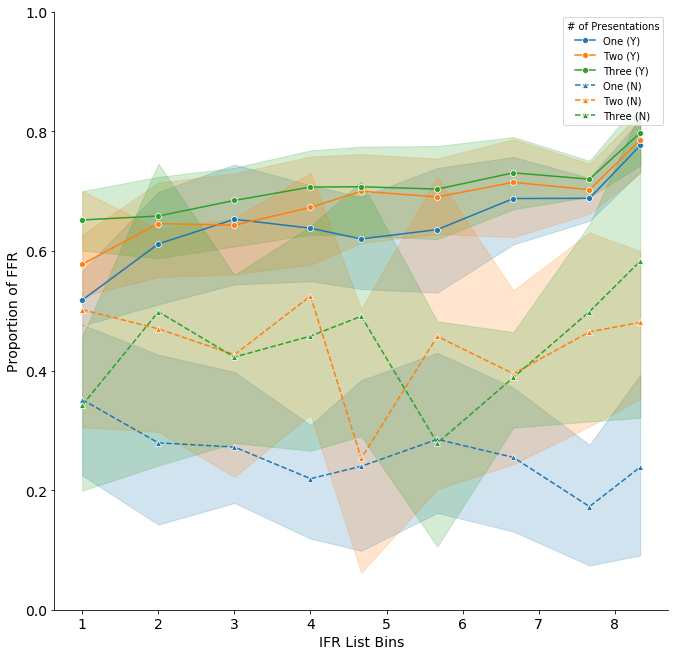

In [189]:

# (counted.groupby(['repeats', 'recalled', 'orig_list']).item_num.sum()/counted.item_num.sum()).reset_index().

# counted[counted.subject=='LTP441'].sort_values(['orig_list', 'repeats', 'recalled'])

# pd.set_option('display.max_rows', None)
# counted.groupby(['repeats', 'recalled', 'orig_list']).item_num.std()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

no_one = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 1)]
no_two = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 2)]
no_thr = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 3)]

ye_one = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 1)]
ye_two = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 2)]
ye_thr = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 3)]

# no_rep = summed.groupby(['sub', 'recalled', 'list']).prop.mean().reset_index()
# no_no = no_rep[no_rep.recalled == 0]
# no_yes = no_rep[no_rep.recalled == 1]


set_axes(figsize = (11, 11), xticks = np.arange(1, 26), ylim = [0,1])
# sns.lineplot(data = no_yes, x = 'list', y = 'prop', linestyle = '-', marker = 'o', label = 'yes', color = 'black')
# sns.lineplot(data = no_no, x = 'list', y = 'prop', linestyle = '--', marker = '^', label = 'no', color = 'black')

g4 = sns.lineplot(data=ye_one, x = 'bin', y = 'prop', marker = 'o', linestyle = '-', label = 'One (Y)', color = colors[0])
g5 = sns.lineplot(data=ye_two, x = 'bin', y = 'prop', marker = 'o', linestyle = '-', label = 'Two (Y)', color = colors[1])
g6 = sns.lineplot(data=ye_thr, x = 'bin', y = 'prop', marker = 'o', linestyle = '-', label = 'Three (Y)', color = colors[2])

g1 = sns.lineplot(data=no_one, x = 'bin', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'One (N)', color = colors[0])
g2 = sns.lineplot(data=no_two, x = 'bin', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Two (N)', color = colors[1])
g3 = sns.lineplot(data=no_thr, x = 'bin', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Three (N)', color = colors[2])


_ = plt.legend(title = '# of Presentations')
_ = plt.xlabel('IFR List Bins')
_ = plt.ylabel('Proportion of FFR')
plt.savefig('scalp_figs/ffr_recalls_binned.pdf')



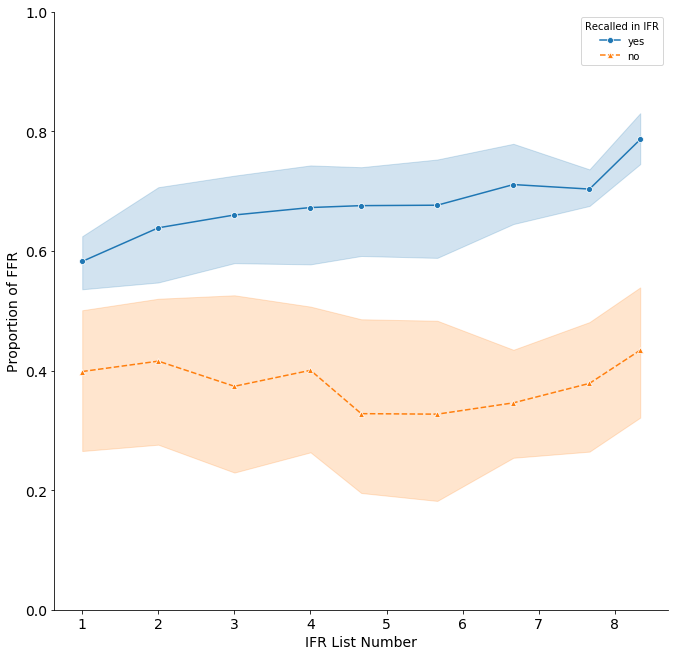

In [190]:
no_rep = summed.groupby(['sub', 'recalled', 'bin']).prop.mean().reset_index()
no_no = no_rep[no_rep.recalled == 0]
no_yes = no_rep[no_rep.recalled == 1]


set_axes(figsize = (11, 11), xticks = np.arange(1, 26), ylim = [0,1])
sns.lineplot(data = no_yes, x = 'bin', y = 'prop', linestyle = '-', marker = 'o', label = 'yes')
sns.lineplot(data = no_no, x = 'bin', y = 'prop', linestyle = '--', marker = '^', label = 'no')

_ = plt.legend(title = 'Recalled in IFR')
_ = plt.xlabel('IFR List Number')
_ = plt.ylabel('Proportion of FFR')

plt.savefig('scalp_figs/ffr_rec_no_reps_binned.pdf')

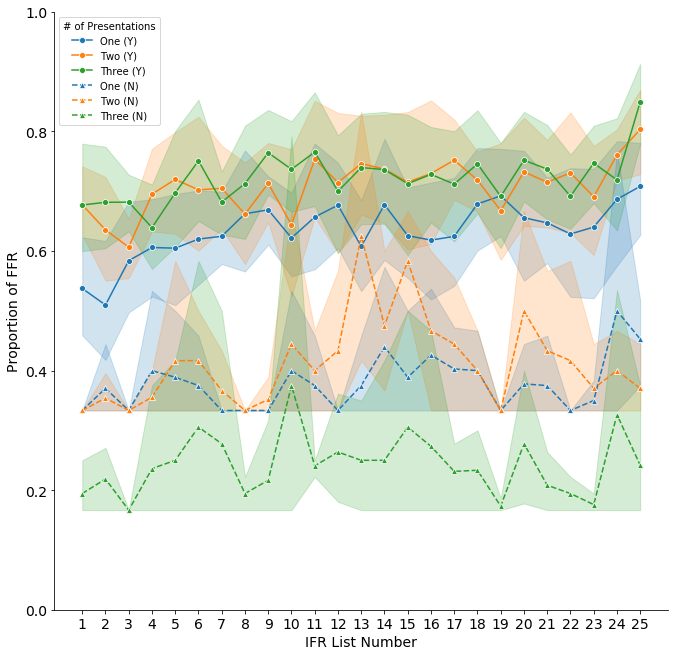

In [191]:
agg=[]
# no_james = evs[evs.subject!= 'LTP442']
for i, beh in evs.groupby(['subject', 'session']):
    word_evs = beh[beh.type=='WORD']
    word_evs = word_evs.loc[word_evs.repeats != -999]
    word_evs = word_evs[word_evs.repeats != 0]
    rec_evs = beh[beh.type=='REC_WORD']
    rec_wrds = word_evs[word_evs.recalled == 1].item_num.unique()
    no_rec = word_evs[word_evs.recalled == 0].item_num.unique()
    ffr = rec_evs[rec_evs.list == 26]
    ffr = ffr[ffr.item_num != -1]
    ffr = ffr.drop_duplicates('item_num')
    word_evs = word_evs.drop_duplicates('item_num')
    count = pd.DataFrame()
    ffr.set_index('item_num', inplace=True)
    word_evs.set_index('item_num', inplace=True)
    ffr['list'] = word_evs.list
    ffr['recalled'] = word_evs.recalled
    ffr.reset_index(inplace=True)
    word_evs.reset_index(inplace=True)
    count['numer'] = ffr.groupby(['repeats', 'recalled', 'list']).item_num.count()
    count = count.reset_index()
    count.at[count.repeats<3, 'denom'] = 3
    count.at[count.repeats==3, 'denom'] = 6
    count.fillna(0, inplace=True)
    sub,sess=i
    count['sub'] = pd.Series(sub, count.index)
    count['sess'] = pd.Series(sess, count.index)
    count = count.reset_index()
    agg.append(count)
counted = pd.concat(agg, ignore_index = True)
summed = counted.groupby(['sub', 'repeats', 'recalled', 'list']).sum()
summed['prop'] = summed.numer/summed.denom
summed.reset_index(inplace=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

no_one = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 1)]
no_two = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 2)]
no_thr = summed.loc[(summed['recalled'] == 0) & (summed['repeats'] == 3)]

ye_one = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 1)]
ye_two = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 2)]
ye_thr = summed.loc[(summed['recalled'] == 1) & (summed['repeats'] == 3)]

set_axes(figsize = (11, 11), xticks = np.arange(1, 26), ylim = [0,1])

g4 = sns.lineplot(data=ye_one, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'One (Y)', color = colors[0])
g5 = sns.lineplot(data=ye_two, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'Two (Y)', color = colors[1])
g6 = sns.lineplot(data=ye_thr, x = 'list', y = 'prop', marker = 'o', linestyle = '-', label = 'Three (Y)', color = colors[2])

g1 = sns.lineplot(data=no_one, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'One (N)', color = colors[0])
g2 = sns.lineplot(data=no_two, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Two (N)', color = colors[1])
g3 = sns.lineplot(data=no_thr, x = 'list', y = 'prop', marker = '^', ci = 95, linestyle ='--', label = 'Three (N)', color = colors[2])

_ = plt.legend(title = '# of Presentations')
_ = plt.xlabel('IFR List Number')
_ = plt.ylabel('Proportion of FFR')

In [52]:
ffr_rec = pd.concat(ffr_rec_agg).reset_index()

ffr_rec = ffr_rec.groupby(['subject', 'orig_list']).item_num.mean().reset_index()

ffr_no = pd.concat(ffr_no_agg).reset_index()
ffr_no = ffr_no.groupby(['subject', 'orig_list']).item_num.mean().reset_index()


set_axes(figsize = (11, 7), xticks = np.arange(1, 26))
sns.lineplot(data=ffr_rec, x = 'orig_list', y = 'item_num', marker = 'o')
sns.lineplot(data=ffr_no, x = 'orig_list', y = 'item_num', marker = '^')
# ffr_rec

NameError: name 'ffr_rec_agg' is not defined

In [57]:
beh = evs[evs.subject == 'LTP441']
beh = beh[beh.session == 8]

word_evs = beh[beh.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = beh[beh.type=='REC_WORD']
rec_wrds = word_evs[word_evs.recalled == 1].item_num.unique()
no_rec = word_evs[word_evs.recalled == 0].item_num.unique()
ffr = rec_evs[rec_evs.list == 26]
ffr = ffr[ffr.item_num != -1]
ffr = ffr.drop_duplicates('item_num')
word_evs = word_evs.drop_duplicates('item_num')

ffr.set_index('item_num', inplace=True)
word_evs.set_index('item_num', inplace=True)
ffr['orig_list'] = word_evs.list
ffr.reset_index(inplace=True)

tot_recs = ffr.groupby(['subject']).item_num.count()
ffr_rec = ffr[ffr.item_num.isin(rec_wrds)]
ffr_no = ffr[ffr.item_num.isin(no_rec)]

ffr_rec = ffr_rec.groupby(['repeats', 'orig_list']).item_num.count()
ffr_rec = ffr_rec/ffr_rec.sum()

ffr_no = ffr_no.groupby(['repeats', 'orig_list']).item_num.count()
ffr_no = ffr_no/ffr_no.sum()

ffr_rec = ffr_rec.reset_index()
ffr_no = ffr_no.reset_index()

ffr_rec['subject'] = pd.Series(sub, index = ffr_rec.index)
ffr_rec['session'] = pd.Series(sess, index = ffr_rec.index)

ffr_no['subject'] = pd.Series(sub, index = ffr_no.index)
ffr_no['session'] = pd.Series(sess, index = ffr_no.index)


In [133]:
beh = evs[evs.subject == 'LTP443']
beh = beh[beh.session == 8]
word_evs = beh[beh.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
word_evs = word_evs[word_evs.repeats != 0]
rec_evs = beh[beh.type=='REC_WORD']
rec_wrds = word_evs[word_evs.recalled == 1].item_num.unique()
no_rec = word_evs[word_evs.recalled == 0].item_num.unique()
ffr = rec_evs[rec_evs.list == 26]
ffr = ffr[ffr.item_num != -1]
ffr = ffr.drop_duplicates('item_num')
word_evs = word_evs.drop_duplicates('item_num')

ffr.set_index('item_num', inplace=True)
word_evs.set_index('item_num', inplace=True)
ffr['orig_list'] = word_evs.list
ffr['recalled'] = word_evs.recalled
ffr.reset_index(inplace=True)
counted = ffr.groupby(['repeats', 'recalled', 'orig_list']).item_num.count()
counted = counted/counted.sum()


# ffr_rec = ffr[ffr.item_num.isin(rec_wrds)]
# ffr_no = ffr[ffr.item_num.isin(no_rec)]

# ffr_rec = ffr_rec.groupby(['repeats', 'orig_list']).item_num.count()
# ffr_rec = ffr_rec/ffr_rec.groupby('repeats').count()

# ffr_no = ffr_no.groupby(['repeats', 'orig_list']).item_num.count()
# ffr_no = ffr_no/ffr_no.groupby('repeats').count()

# ffr_rec = ffr_rec.reset_index()
# ffr_no = ffr_no.reset_index()
# ffr_rec['subject'] = pd.Series(sub, index = ffr_rec.index)
# ffr_vrec['session'] = pd.Series(sess, index = ffr_rec.index)

# ffr_no['subject'] = pd.Series(sub, index = ffr_no.index)
# ffr_no['session'] = pd.Series(sess, index = ffr_no.index)

# ffr_no

1.0

In [ ]:
ffr_rec_agg = []
ffr_no_agg = []
for i, beh in evs.groupby(['subject', 'session']):
    sub, sess = i
    word_evs = beh[beh.type=='WORD']
    word_evs = word_evs.loc[word_evs.repeats != -999]
    word_evs = word_evs[word_evs.repeats != 0]
    rec_evs = beh[beh.type=='REC_WORD']
    rec_wrds = word_evs[word_evs.recalled == 1].item_num.unique()
    no_rec = word_evs[word_evs.recalled == 0].item_num.unique()
    ffr = rec_evs[rec_evs.list == 26]
    ffr = ffr[ffr.item_num != -1]
    ffr = ffr.drop_duplicates('item_num')
    word_evs = word_evs.drop_duplicates('item_num')

    ffr.set_index('item_num', inplace=True)
    word_evs.set_index('item_num', inplace=True)
    ffr['orig_list'] = word_evs.list
    ffr.reset_index(inplace=True)

    ffr_rec = ffr[ffr.item_num.isin(rec_wrds)]
    ffr_no = ffr[ffr.item_num.isin(no_rec)]

    ffr_rec = ffr_rec.groupby(['repeats', 'orig_list']).item_num.count()
    ffr_rec = ffr_rec/ffr_rec.groupby('repeats').count()

    ffr_no = ffr_no.groupby(['repeats', 'orig_list']).item_num.count()
    ffr_no = ffr_no/ffr_no.groupby('repeats').count()

    ffr_rec = ffr_rec.reset_index()
    ffr_no = ffr_no.reset_index()
    ffr_rec['subject'] = pd.Series(sub, index = ffr_rec.index)
    ffr_rec['session'] = pd.Series(sess, index = ffr_rec.index)

    ffr_no['subject'] = pd.Series(sub, index = ffr_no.index)
    ffr_no['session'] = pd.Series(sess, index = ffr_no.index)

    ffr_rec_agg.append(ffr_rec)
    ffr_no_agg.append(ffr_no)